# Quantum GAN com Pennylane e MedMNIST

Este notebook apresenta uma implementação simplificada de uma GAN quântica inspirada no método de *patches* descrito por Huang et al. Utilizamos o dataset **MedMNIST** para comparação com os modelos clássicos.

## 1. Setup Quântico
Instalação de `pennylane` e demais bibliotecas necessárias para execução do modelo híbrido.

In [1]:
!pip install pennylane pennylane-lightning torch medmnist matplotlib --quiet
import torch
import pennylane as qml
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import medmnist
from medmnist import INFO
import matplotlib.pyplot as plt

## 2. Preparação do Dataset
Utilizamos o mesmo subset do notebook clássico para permitir comparação direta. Pode ser necessário reduzir a resolução das imagens para se adequar ao número de qubits disponíveis.

In [2]:
# Seleciona o dataset
DATA_FLAG = 'breastmnist'
info = INFO[DATA_FLAG]
download = True

transform = transforms.Compose([
    #transforms.Resize((8, 8)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


# Carrega treino e teste
train_dataset = getattr(medmnist, info['python_class'])(split='train', transform=transform, download=download)
test_dataset = getattr(medmnist, info['python_class'])(split='test', transform=transform, download=download)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Using downloaded and verified file: /home/mahlow/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/mahlow/.medmnist/breastmnist.npz


In [3]:
print(train_dataset)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /home/mahlow/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0


In [4]:
# Separa conjuntos por rótulo
def subset_by_label(dataset, label):
    idx = [i for i in range(len(dataset)) if int(dataset.labels[i]) == label]
    return Subset(dataset, idx)

train_loader_0 = DataLoader(subset_by_label(train_dataset, 0), batch_size=batch_size, shuffle=True)
train_loader_1 = DataLoader(subset_by_label(train_dataset, 1), batch_size=batch_size, shuffle=True)


/tmp/ipykernel_8826/2877601772.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  idx = [i for i in range(len(dataset)) if int(dataset.labels[i]) == label]


NameError: name 'Subset' is not defined

## 3. Implementação da Quantum GAN
Seguimos o tutorial da Pennylane para criar o gerador quântico por patches. O discriminador permanece clássico.

In [ ]:
# Variáveis do circuito
n_qubits = 5
n_a_qubits = 1
q_depth = 6
n_generators = 49

class Discriminator(nn.Module):
    def __init__(self, img_size=8):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(img_size * img_size, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)


In [ ]:
# Dispositivo quântico
dev = qml.device('lightning.qubit', wires=n_qubits)

@qml.qnode(dev, diff_method='parameter-shift')
def quantum_circuit(noise, weights):
    weights = weights.reshape(q_depth, n_qubits)
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)
    for i in range(q_depth):
        for j in range(n_qubits):
            qml.RY(weights[i][j], wires=j)
        for j in range(n_qubits-1):
            qml.CZ(wires=[j, j+1])
    return qml.probs(wires=list(range(n_qubits)))

def partial_measure(noise, weights):
    probs = quantum_circuit(noise, weights).clone().detach()
    probs_given = probs[:2 ** (n_qubits - n_a_qubits)]
    probs_given /= torch.sum(probs_given)
    probs_given = probs_given / torch.max(probs_given)
    return probs_given

In [31]:
class PatchQuantumGenerator(nn.Module):
    def __init__(self, n_generators, q_delta=1.):
        super().__init__()
        self.q_params = nn.ParameterList([
            nn.Parameter(q_delta*torch.rand(q_depth*n_qubits))
            for _ in range(n_generators)
        ])
        self.n_generators = n_generators

    def forward(self, x):
        patch_size = 2**(n_qubits-n_a_qubits)
        device = x.device  # garante que criamos tensores no dispositivo correto
        images = torch.empty(x.size(0), 0, device=device)
        for params in self.q_params:
            patches = torch.empty(0, patch_size, device=device)
            for elem in x:
                q_out = partial_measure(elem, params).float().unsqueeze(0).to(device)
                patches = torch.cat((patches, q_out))
            images = torch.cat((images, patches), 1)
        return images.view(x.size(0), 1, 28, 28)


## 4. Treinamento
Define a função de perda adversarial e executa um ciclo de treinamento simplificado.

In [32]:
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
D = Discriminator(img_size=28).to(device)
G = PatchQuantumGenerator(n_generators).to(device)

criterion = nn.BCELoss()
optD = torch.optim.SGD(D.parameters(), lr=1e-2)
optG = torch.optim.SGD(G.parameters(), lr=3e-1)

# Para medir o tempo total
total_start = time.time()

num_iter = 500
for it in range(num_iter):
    iter_start = time.time()  # marca início da iteração

    for real, _ in train_loader:
        real = real.to(device)
        b_size = real.size(0)

        # Labels dinâmicos
        real_label = torch.ones((b_size, 1), device=device)
        fake_label = torch.zeros((b_size, 1), device=device)

        # Gera fake
        noise = torch.rand(b_size, n_qubits, device=device) * torch.pi / 2
        fake = G(noise)

        # Treina D
        optD.zero_grad()
        out_real = D(real)
        out_fake = D(fake.detach())
        loss_D = criterion(out_real, real_label) + criterion(out_fake, fake_label)
        loss_D.backward()
        optD.step()

        # Treina G
        optG.zero_grad()
        out_fake = D(fake)
        loss_G = criterion(out_fake, real_label)
        loss_G.backward()
        optG.step()

    # fim da iteração
    iter_time = time.time() - iter_start
    print(f"Iter {it+1}: Loss D {loss_D.item():.3f}, Loss G {loss_G.item():.3f} — tempo iteração: {iter_time:.2f}s")

    # visualização só na primeira iteração, se quiser
    if (it + 1) % 50 == 0:
        noise_eval = torch.rand(8, n_qubits, device=device) * torch.pi/2
        with torch.no_grad():
            full_images = G(noise_eval).detach().cpu()
        fig, axes = plt.subplots(1, len(noise_eval), figsize=(len(noise_eval)*2, 2))
        for j, ax in enumerate(axes.flat):
            ax.imshow(full_images[j, 0], cmap='gray')
            ax.axis('off')
        plt.tight_layout()
        plt.show()

# depois de tudo
total_time = time.time() - total_start
print(f"Tempo total de treinamento: {total_time:.2f}s")

KeyboardInterrupt: 

### 4.1 Treinamento separado por classe
Treinamos dois geradores: um para imagens malignas (rótulo 0) e outro para imagens benignas (rótulo 1).

In [41]:
import time

def train_quantum_gan(loader, G, D, epochs=50, device='cuda' if torch.cuda.is_available() else 'cpu'):
    criterion = nn.BCELoss()
    optD = torch.optim.SGD(D.parameters(), lr=1e-2)
    optG = torch.optim.SGD(G.parameters(), lr=3e-1)
    hist_D, hist_G = [], []

    total_start = time.time()
    for epoch in range(epochs):
        epoch_start = time.time()
        epoch_loss_D = 0
        epoch_loss_G = 0
        for real, _ in loader:
            real = real.to(device)
            b_size = real.size(0)
            real_label = torch.ones((b_size, 1), device=device)
            fake_label = torch.zeros((b_size, 1), device=device)
            noise = torch.rand(b_size, n_qubits, device=device) * torch.pi/2
            fake = G(noise)

            # Update Discriminator
            optD.zero_grad()
            out_real = D(real)
            out_fake = D(fake.detach())
            loss_D = criterion(out_real, real_label) + criterion(out_fake, fake_label)
            loss_D.backward()
            optD.step()

            # Update Generator
            optG.zero_grad()
            out_fake = D(fake)
            loss_G = criterion(out_fake, real_label)
            loss_G.backward()
            optG.step()

            epoch_loss_D += loss_D.item()
            epoch_loss_G += loss_G.item()

        hist_D.append(epoch_loss_D / len(loader))
        hist_G.append(epoch_loss_G / len(loader))
        epoch_time = time.time() - epoch_start
        print(f'Epoch {epoch+1}: D {hist_D[-1]:.4f} G {hist_G[-1]:.4f} - Epoch Time: {epoch_time:.2f}s')

    total_time = time.time() - total_start
    print(f'Training completed in {total_time:.2f}s')
    return hist_D, hist_G

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
G_mal = PatchQuantumGenerator(n_generators).to(device)
D_mal = Discriminator(img_size=28).to(device)
loss_D_mal, loss_G_mal = train_quantum_gan(train_loader_0, G_mal, D_mal, epochs=10, device=device)

G_ben = PatchQuantumGenerator(n_generators).to(device)
D_ben = Discriminator(img_size=28).to(device)
loss_D_ben, loss_G_ben = train_quantum_gan(train_loader_1, G_ben, D_ben, epochs=10, device=device)


Epoch 1: D 1.3908 G 0.6686 - Epoch Time: 81.18s


### Curvas de Loss

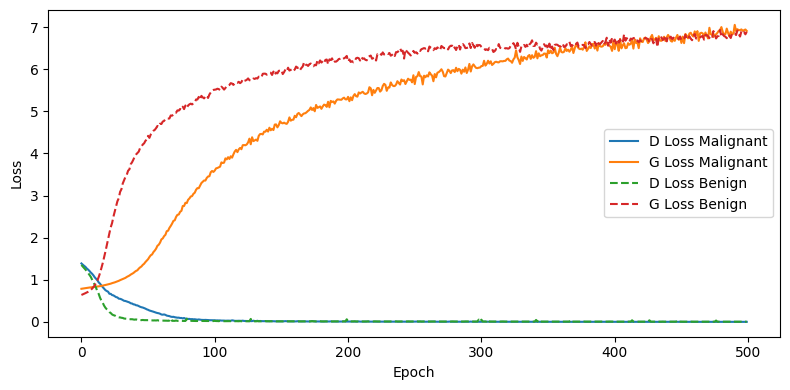

In [49]:
plt.figure(figsize=(8,4))
plt.plot(loss_D_mal, label='D Loss Malignant')
plt.plot(loss_G_mal, label='G Loss Malignant')
plt.plot(loss_D_ben, label='D Loss Benign', linestyle='--')
plt.plot(loss_G_ben, label='G Loss Benign', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


## 5. Avaliação
Utilize as mesmas métricas (FID e IS) para comparar as imagens geradas pela abordagem quântica.

In [56]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import pandas as pd

def evaluate_gan(
    G,
    label_target: int,
    gan_name: str,
    gen_label_name: str,
    test_dataset,
    n_qubits: int,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    max_batches: float = float('inf')
):
    """
    Avalia um gerador GAN usando FID e Inception Score.
    
    Correções aplicadas:
      - usa normalize=True tanto em FID quanto em InceptionScore, para aceitar tensores float em [0,1].
      - converte imagens grayscale (1 canal) em RGB (3 canais).
      - redimensiona tudo para 299×299 (requisito do InceptionV3).
    """
    loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # normalize=True: aceita floats em [0,1] e faz o cast interno para uint8
    fid = FrechetInceptionDistance(feature=64, normalize=True).to(device)
    is_metric = InceptionScore(normalize=True).to(device)
    
    G = G.to(device)
    G.eval()
    
    count = 0
    for real, labels in loader:
        mask = (labels.squeeze() == label_target)
        if mask.sum() == 0:
            continue
        
        # real: [B,1,H,W], floats em [0,1]
        real = real[mask].to(device)
        real = real.repeat(1, 3, 1, 1)  # -> [B,3,H,W]
        real = F.interpolate(real, size=(299, 299), mode='bilinear', align_corners=False)
        
        b_size = real.size(0)
        noise = torch.rand(b_size, n_qubits, device=device) * (torch.pi / 2)
        
        with torch.no_grad():
            fake = G(noise)  # supõe saída [B,1,H,W], floats em [0,1]
        fake = fake.to(device)
        fake = fake.repeat(1, 3, 1, 1)  # -> [B,3,H,W]
        fake = F.interpolate(fake, size=(299, 299), mode='bilinear', align_corners=False)
        
        # atualiza métricas com floats em [0,1]
        fid.update(real, real=True)
        fid.update(fake, real=False)
        is_metric.update(fake)
        
        count += 1
        if count >= max_batches:
            break
    
    fid_score = fid.compute().item()
    is_mean, is_std = is_metric.compute()
    
    return {
        'GAN': gan_name,
        'Generator_Label': gen_label_name,
        'Real_Label': 'Malignant' if label_target == 0 else 'Benign',
        'FID': fid_score,
        'IS_Mean': is_mean.item(),
        'IS_Std': is_std.item()
    }

# Exemplo de uso:
results = []
results.append(evaluate_gan(G_mal, 0, 'QuantumGAN', 'Malignant', test_dataset, n_qubits))
results.append(evaluate_gan(G_ben, 1, 'QuantumGAN', 'Benign',   test_dataset, n_qubits))
results_df = pd.DataFrame(results)
results_df


,GAN,Generator_Label,Real_Label,FID,IS_Mean,IS_Std
0,QuantumGAN,Malignant,Malignant,6.255424,1.259082,0.091074
1,QuantumGAN,Benign,Benign,7.000401,1.380240,0.140491


## Classificação com ResNet

In [57]:
from torchvision.models import resnet18
import torch.nn.functional as F
from torch.utils.data import Dataset, ConcatDataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def custom_collate_fn(batch):
    xs, ys = zip(*batch)
    xs = torch.stack(xs, dim=0)
    ys_list = []
    for y in ys:
        if isinstance(y, torch.Tensor):
            val = y.item() if y.numel() == 1 else int(y.argmax().item())
        else:
            val = int(y)
        ys_list.append(val)
    ys = torch.tensor(ys_list, dtype=torch.long)
    return xs, ys

class SyntheticDataset(Dataset):
    def __init__(self, generator_dict, num_per_class, latent_dim, device=None):
        self.samples = []
        device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        for label_name, gen in generator_dict.items():
            label = 0 if label_name == 'malignant' else 1
            noise = torch.rand(num_per_class, n_qubits, device=device) * torch.pi/2
            with torch.no_grad():
                imgs = gen(noise).cpu()
            for img in imgs:
                self.samples.append((img, label))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        return self.samples[idx]

def train_model(model, loader, epochs=5, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for _ in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()

def evaluate(model, loader, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            preds = out.argmax(dim=1).cpu()
            all_preds.append(preds)
            all_labels.append(y)
    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auc = float('nan')
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return acc, prec, rec, f1, auc, tn, fp, fn, tp

def run_experiments(train_dataset, test_dataset, G_dict, batch_size=32, epochs=5, device=None):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    latent_dim = n_qubits
    ratios = [0.0, 0.25, 0.5, 0.75, 1.0, 1.5]
    results = []
    for r in ratios:
        if r == 0.0:
            ds = train_dataset
        else:
            num_syn = int(len(train_dataset) * r)
            syn_ds = SyntheticDataset(G_dict, num_syn // 2, latent_dim, device)
            ds = ConcatDataset([train_dataset, syn_ds])
        loader = DataLoader(ds, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
        model = resnet18(num_classes=2)
        model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
        train_model(model, loader, epochs=epochs, device=device)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
        acc, prec, rec, f1, auc, tn, fp, fn, tp = evaluate(model, test_loader, device=device)
        results.append({'ratio': r,'acc': acc,'prec': prec,'rec': rec,'f1': f1,'auc': auc,'tn': tn,'fp': fp,'fn': fn,'tp': tp})
    syn_only_ds = SyntheticDataset(G_dict, len(train_dataset)//2, latent_dim, device)
    syn_loader = DataLoader(syn_only_ds, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    model = resnet18(num_classes=2)
    model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    train_model(model, syn_loader, epochs=epochs, device=device)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
    acc, prec, rec, f1, auc, tn, fp, fn, tp = evaluate(model, test_loader, device=device)
    results.append({'ratio':'100%_sintético→real','acc':acc,'prec':prec,'rec':rec,'f1':f1,'auc':auc,'tn':tn,'fp':fp,'fn':fn,'tp':tp})
    total_syn = len(syn_only_ds)
    n_train = int(total_syn * 0.7)
    n_test = total_syn - n_train
    syn_train_ds, syn_test_ds = random_split(syn_only_ds, [n_train, n_test])
    train_loader = DataLoader(syn_train_ds, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    test_loader = DataLoader(syn_test_ds, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
    model = resnet18(num_classes=2)
    model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    train_model(model, train_loader, epochs=epochs, device=device)
    acc, prec, rec, f1, auc, tn, fp, fn, tp = evaluate(model, test_loader, device=device)
    results.append({'ratio':'100%_sintético_70/30_selftest','acc':acc,'prec':prec,'rec':rec,'f1':f1,'auc':auc,'tn':tn,'fp':fp,'fn':fn,'tp':tp})
    return pd.DataFrame(results)


In [58]:
G_dict = {'malignant': G_mal, 'benign': G_ben}
classification_results = run_experiments(train_dataset, test_dataset, G_dict, batch_size=64, epochs=5)
classification_results


/tmp/ipykernel_60846/1243825210.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)
/tmp/ipykernel_60846/1243825210.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)
/tmp/ipykernel_60846/1243825210.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = int(y)
/tmp/ipykernel_60846/1243825210.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a singl

,ratio,acc,prec,rec,f1,auc,tn,fp,fn,tp
0,0.0,0.826923,0.891892,0.868421,0.880000,0.791353,30,12,15,99
1,0.25,0.820513,0.864407,0.894737,0.879310,0.756892,26,16,12,102
2,0.5,0.807692,0.823077,0.938596,0.877049,0.695489,19,23,7,107
3,0.75,0.839744,0.850394,0.947368,0.896266,0.747494,23,19,6,108
4,1.0,0.801282,0.867257,0.859649,0.863436,0.751253,27,15,16,98
5,1.5,0.717949,0.948718,0.649123,0.770833,0.776942,38,4,40,74
6,100%_sintético→real,0.698718,0.727891,0.938596,0.819923,0.493108,2,40,7,107
7,100%_sintético_70/30_selftest,0.993902,0.987013,1.000000,0.993464,0.994318,87,1,0,76
